German Traffic Sign Recognition Benchmark (GTSRB)
=================================================
---
Introduction au Deep Learning  (IDLE) - S. Aria, E. Maldonado, JL. Parouty - CNRS/SARI/DEVLOG - 2020

## Episode 3 : Tracking and visualizing

Our main steps:
 - Monitoring and understanding our model training
 - Analyze the results 
 - Improving our model
 - Add recovery points


## 1/ Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from importlib import reload

import idle.pwk as ooo

ooo.init()

IDLE 2020 - Practical Work Module
  Version            : 0.1.1
  Run time           : Monday 6 January 2020, 20:52:54
  Matplotlib style   : idle/talk.mplstyle
  TensorFlow version : 2.0.0
  Keras version      : 2.2.4-tf


## 2/ Reload dataset
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use the dataset : **L25**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [2]:
%%time

dataset ='L25'
img_lx  = 25
img_ly  = 25
img_lz  = 1

# ---- Read dataset
x_train = np.load('./data/{}/x_train.npy'.format(dataset))
y_train = np.load('./data/{}/y_train.npy'.format(dataset))

x_test  = np.load('./data/{}/x_test.npy'.format(dataset))
y_test  = np.load('./data/{}/y_test.npy'.format(dataset))

# ---- Reshape data
x_train = x_train.reshape( x_train.shape[0], img_lx, img_ly, img_lz)
x_test  = x_test.reshape(  x_test.shape[0],  img_lx, img_ly, img_lz)

input_shape = (img_lx, img_ly, img_lz)

print("Dataset loaded, size={:.1f} Mo\n".format(ooo.get_directory_size('./data/'+dataset)))

Dataset loaded, size=247.6 Mo

CPU times: user 0 ns, sys: 297 ms, total: 297 ms
Wall time: 330 ms


## 3/ Have a look to the dataset
Note: Data must be reshape for matplotlib

x_train :  (39209, 25, 25, 1)
y_train :  (39209,)
x_test  :  (12630, 25, 25, 1)
y_test  :  (12630,)


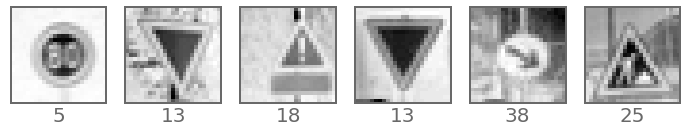

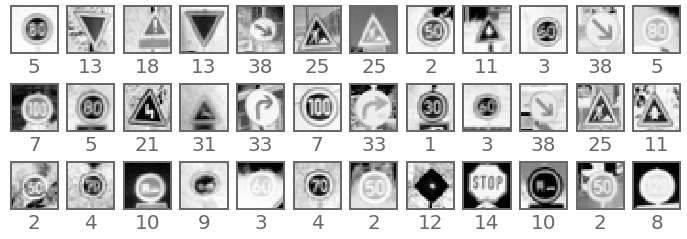

In [3]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

if img_lz>1:
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly,img_lz), y_train, range(6),  columns=3,  x_size=4, y_size=3)
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly,img_lz), y_train, range(36), columns=12, x_size=1, y_size=1)
else:
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly), y_train, range(6),  columns=6,  x_size=2, y_size=2)
    ooo.plot_images(x_train.reshape(-1,img_lx,img_ly), y_train, range(36), columns=12, x_size=1, y_size=1)

## 4/ Create model

In [4]:
batch_size  =  64
num_classes =  43
epochs      =  20

In [5]:
model = keras.models.Sequential()
model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(img_lx, img_ly, img_lz)))
model.add( keras.layers.MaxPooling2D((2, 2)))
model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
model.add( keras.layers.MaxPooling2D((2, 2)))
model.add( keras.layers.Flatten()) 
model.add( keras.layers.Dense(3072, activation='relu'))
model.add( keras.layers.Dense(500, activation='relu'))
model.add( keras.layers.Dense(500, activation='relu'))
model.add( keras.layers.Dense(43, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 23, 23, 96)        960       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 192)         166080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 192)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 3072)              9440256   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1

## 5/ Add callbacks
Nous allons ajouter 2 callbacks :  
 - **TensorBoard**  
Training logs, which can be visualised with Tensorboard.  
`#tensorboard --logdir ./run/logs`  
 - model backup

In [7]:
# reload(ooo)
# ---- Callback for tensorboard
log_dir="./run/logs/" + ooo.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## 5/ Run model

In [8]:
%%time

history = model.fit(  x_train[:3000], y_train[:3000],
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback] )

Train on 3000 samples, validate on 12630 samples
Epoch 1/20
3000/3000 [==============================] - 12s 4ms/sample - loss: 3.4839 - accuracy: 0.0740 - val_loss: 3.1409 - val_accuracy: 0.1995
Epoch 2/20
3000/3000 [==============================] - 12s 4ms/sample - loss: 2.4676 - accuracy: 0.3067 - val_loss: 2.1162 - val_accuracy: 0.3968
Epoch 3/20
3000/3000 [==============================] - 13s 4ms/sample - loss: 1.4458 - accuracy: 0.5543 - val_loss: 1.4468 - val_accuracy: 0.5862
Epoch 4/20
3000/3000 [==============================] - 14s 5ms/sample - loss: 0.9291 - accuracy: 0.7067 - val_loss: 1.1903 - val_accuracy: 0.6622
Epoch 5/20
3000/3000 [==============================] - 14s 5ms/sample - loss: 0.6027 - accuracy: 0.8030 - val_loss: 0.8067 - val_accuracy: 0.7900
Epoch 6/20
3000/3000 [==============================] - 14s 5ms/sample - loss: 0.3835 - accuracy: 0.8670 - val_loss: 0.8453 - val_accuracy: 0.7925
Epoch 7/20
3000/3000 [==============================] - 14s 5ms/sampl

## 6/ Evaluation

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

## 7/ History
The return of model.fit() returns us the learning history

In [ ]:
ooo.plot_history(history)

---
### Results :  
L25 : size=250 Mo, 93.15%  
...